In [1]:
from kili.client import Kili
from pathlib import Path
import os
import pandas as pd
import json
import numpy as np
import cv2
import json
import os
from PIL import Image
import matplotlib.pyplot as plt


After images were annotated in KILI, the images and the JSON file the positional data of the segmentation masks was downloaded on a local drive.
An  API key was used for this. 
Choosing 'single_file' means that all annotation data will be in one JSON file. 
The images are exported in KILI format, meaning the coming section will convert it to pixelwise annotation such that the mask will be compatible with SegFormer.

source code: https://python-sdk-docs.kili-technology.com/latest/sdk/tutorials/export_a_kili_project/

In [2]:
#Setting API key and using OS lib to access the project in KILI.
os.environ['KILI_API_KEY'] = 'e6eb6361-cf3c-44aa-b258-010b64047ccf'

kili = Kili()



#exporting project to local directory
kili.export_labels(
    project_id="cls8xp2yj2xkl011faote2ivg", 
    filename="/Users/mithilathangaraj/Desktop/Speciale/Images/export1.zip",
    fmt="kili",
    single_file=True,
)

/Users/mithilathangaraj/Desktop/Speciale/Images/export1.zip


After downloading the ZIP file and decompressing it, a folder with images and a JSON file is visible. 
The JSON file and image folder is needed to generate a mask for each image. 
After inspecting the JSON file, it is possible to see that the vertices are normalized in the JSON file, meaning the position of the mask is has values from 0-1. In order for the mask to be visible the normalized vertices need to be denormalized. The first function denormalizes the vertices. 


class_ids is a dictionary consistent with the label names in the JSON file. It is used to assign a color value to each class. 

sourcecode: inspiration from https://medium.com/@deekshithadp96/how-to-create-a-batch-of-masks-or-ground-truth-images-from-labelme-json-annotations-for-an-image-bd3affc32f34. 


In [ ]:
#Function to denormalize the normalized vertices in the JSON file. De 'denormalization' is done by scaling the vertices which is corresponding to 'x' and 'y' key in the JSON file.
#The scaling factor will be the height and width the images corresponding to the mask of which the vertices are within. 
def normalize_vertices(vertices, image_width, image_height):
    return np.array([[(int(vertex['x'] * image_width), int(vertex['y'] * image_height)) for vertex in vertices]], np.int32)


#dictionary to assign color values to each class. 
class_ids = {
    'BACKGROUND': (0, 0, 0),
    'LOW_1_3': (0, 255, 0),
    'HIGH_4_5': (0, 0, 255)
}

#Defining path to JSON file
json_file_path = '/Users/mithilathangaraj/Desktop/Speciale/Images/export1/data.json'
#Definting path to images
images_dir = '/Users/mithilathangaraj/Desktop/Speciale/Images/export1'
#Defining path fo labels
masks_dir = '/Users/mithilathangaraj/Desktop/Speciale/Images/export1/labels'

#Checking if the masks_dir exists e.g. if the folder is created correctly. 
if not os.path.exists(masks_dir):
    os.makedirs(masks_dir)
#Opening the JSON file
with open(json_file_path, 'r') as file:
    annotations = json.load(file)

#Each images is loaded in original_image and 
for annotation in annotations:
    image_path = os.path.join(images_dir, annotation['content'])
    original_image = cv2.imread(image_path)
    
#image height and width is extracted and number of channels is also defined here. Since the masks are generated in RGB, there are 3 channels. 
    image_height, image_width = original_image.shape[:2]
    mask = np.zeros((image_height, image_width, 3), dtype=np.uint8)

#Iterating through the JSON file to find the right keys and create the masks:
#Everything within ' ' is a key that is used during the iteration. 'latestLabel' and 'jsonResponse' is the entry point of the JSON file. 
    jsonResponse = annotation.get('latestLabel', {}).get('jsonResponse', {})
    #The vertices are scaled due to the denormalization using normalizedVertices function. The positional information about the mask is in 'boundingPoly'.
    if 'OBJECT_DETECTION_JOB' in jsonResponse:
        for obj in jsonResponse['OBJECT_DETECTION_JOB']['annotations']:
            vertices = normalize_vertices(obj['boundingPoly'][0]['normalizedVertices'], image_width, image_height)
            #'children' key contain information about the label name. If the label names LOW_1_3 or HIGH_4_5 is found, the mask is filled using cv2.fillPoly. 
            if 'children' in obj:
                for child_key in obj['children']:
                    child_job = obj['children'][child_key]
                    for category in child_job['categories']:
                        sub_category = category['name'].replace(' ', '_').upper()
                        #The labels are assigned to the class ids created in class_ids above and the masks are colored accordingly. 
                        if sub_category in ['LOW_1_3', 'HIGH_4_5']:
                            cv2.fillPoly(mask, vertices, class_ids[sub_category])
                            
                            
    #Creating fileformat for the mask                        
    mask_filename = os.path.basename(image_path).replace('.JPG.jpg', '.jpg')
    #saving the mask in the mask directorry
    cv2.imwrite(os.path.join(masks_dir, mask_filename), mask)



Masks are now generated and cleansing of the masks and images are needed before feeding the data to a model. 

In [37]:
#Function to remove '.JPG' from filenames in the images_dir. Also doing the same for the masks; in line 14 replacing '' with '.png' and line 23 folder is switched to the masks directory. 
def rename_files(folder_path):
    # List all files in the folder
    file_list = os.listdir(folder_path)
    
    #iterating through each file in the folder
    for file_name in file_list:
        #checking if the file name contains '.JPG'
        if '.JPG' in file_name:
            #constructing the full path to the file
            old_file_path = os.path.join(folder_path, file_name)
            
            #constructing the new file name by replacing '.JPG' with ''
            new_file_name = file_name.replace('.JPG', '')
            
            #constructing the full path to the new file
            new_file_path = os.path.join(folder_path, new_file_name)
            
            #renaming the file
            os.rename(old_file_path, new_file_path)

#path to the assets folder
assets_folder_path = '/Users/mithilathangaraj/Desktop/Speciale/Images/export1/assets'

#rename files in the assets folder
rename_files(assets_folder_path)

Investigating label distribution. 

Label Distribution:
LOW_1_3: 1677
HIGH_4_5: 1393
BACKGROUND: 985


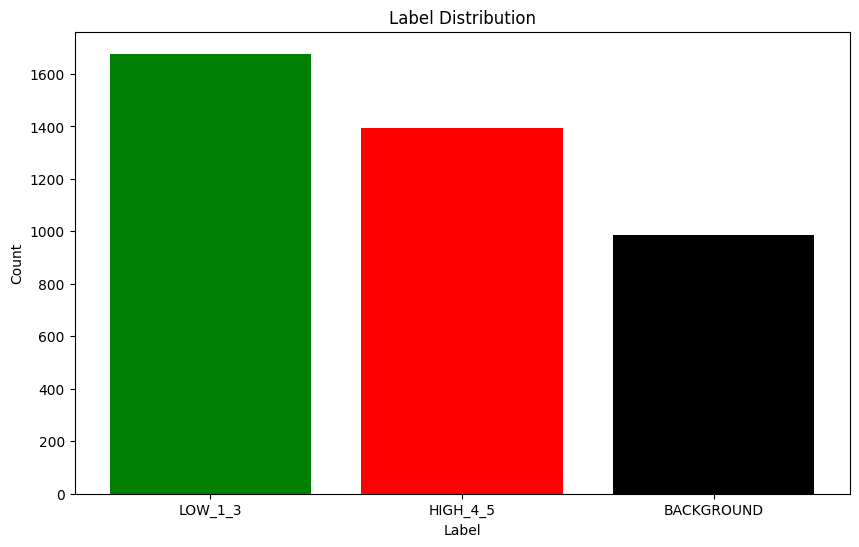

In [6]:
#Function to count the labels in the JSON file. First checks if the data contains a dictionary or a list.
def count_labels(data, label_counts):
    if isinstance(data, dict):
        for key, value in data.items():
            if isinstance(value, (dict, list)):
                count_labels(value, label_counts)
                #if the everytime the keyname in interest is met, the counter collects that information. 
            elif key == 'name' and value.replace(' ', '_').upper() in label_counts:
                label_counts[value.replace(' ', '_').upper()] += 1
    elif isinstance(data, list):
        for item in data:
            count_labels(item, label_counts)


#loading the JSON content from the file
with open(json_file_path, 'r') as f:
    data = json.load(f)

#initializing a dictionary to count labels, starting point is always 0. 
label_counts = {'LOW_1_3': 0, 'HIGH_4_5': 0, 'BACKGROUND': 0}

#using the function and counting labels in the JSON file
count_labels(data, label_counts)

#printing the distribution of labels
print("Label Distribution:")
for label, count in label_counts.items():
    print(f"{label}: {count}")

#plotting using matplotlib
import matplotlib.pyplot as plt

#data for plotting
categories = list(label_counts.keys())
counts = list(label_counts.values())

#creating a bar plot for label distribution
plt.figure(figsize=(10, 6))
plt.bar(categories, counts, color=['green', 'red', 'black'])
plt.title('Label Distribution')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()





Lastly, checking if the masks are created correctly by visualizing them. 

In [ ]:
#file name for the example image - 
file_name = 'debriscat4_30.jpg' 



#constructing the full path to the image and mask and changing the fileformat for masks from JPG to PNG. 
image_path = image_dir / file_name
mask_path = mask_dir / file_name.replace('.jpg', '.png')

#loading the image and the mask using PIL library
image = Image.open(image_path)
mask = Image.open(mask_path)

# setup of plot with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

#displaying the image
axs[0].imshow(image)
axs[0].set_title('Original Image')
axs[0].axis('off')  # Turn off axis numbers and ticks

#displaying the mask - please notice 
axs[1].imshow(mask, cmap='RGB')  
axs[1].set_title('True Mask')
axs[1].axis('off') 

plt.show()
